<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-Finance/blob/master/StockPrediction_Amazon_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-stock-1

Credits: https://github.com/Kulbear/stock-prediction

In [204]:
!git clone https://github.com/Kulbear/stock-prediction
%cd stock-prediction

Cloning into 'stock-prediction'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), done.
/content/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction


# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [205]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [206]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [207]:
!pip install yfinance
import yfinance as yf
tickers = ['AMZN']
# ohlc = yf.download(tickers, start="2001-1-1", end="2007-07-01")
ohlc = yf.download(tickers, start="2010-1-1", end="2019-02-01")
#print (ohlc)
print(list(ohlc.columns.values))
# ohlc.head()
ohlc_reversed = ohlc.sort_values(['Date'], ascending=[False])
print (ohlc_reversed)

print (df)

df = ohlc_reversed


[*********************100%***********************]  1 of 1 completed
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
                   Open         High  ...    Adj Close    Volume
Date                                  ...                       
2019-01-31  1692.849976  1736.410034  ...  1718.729980  10910300
2019-01-30  1623.000000  1676.949951  ...  1670.430054   5783800
2019-01-29  1631.270020  1632.380005  ...  1593.880005   4632800
2019-01-28  1643.589966  1645.000000  ...  1637.890015   4837700
2019-01-25  1670.500000  1683.479980  ...  1670.569946   4945900
...                 ...          ...  ...          ...       ...
2010-01-08   130.559998   133.679993  ...   133.520004   9830500
2010-01-07   132.009995   132.320007  ...   130.000000  11030200
2010-01-06   134.600006   134.729996  ...   132.250000   7178800
2010-01-05   133.429993   135.479996  ...   134.690002   8851900
2010-01-04   136.250000   136.610001  ...   133.899994   7599900

[2285 rows x 6 columns]
     

## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [208]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

Split the data to X_train, y_train, X_test, y_test

In [209]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    ## Probably here add another column as the label.
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    # print (result)
    # print (row)
    print (train[:, : -1])
    print (train[:, -1][: ,-1]) 

    print (result[int(row) :, -1][ : ,-1]) 

    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

 

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [210]:
def build_model(layers):

    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation='linear'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary() 
    print("Compilation Time : ", time.time() - start)
    return model

In [211]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# print (X_train)
# print (y_train)
# print (X_test)
# print (y_test)

[[[1.36250000e+02 1.36610001e+02 1.33139999e+02 1.33899994e+02
   1.33899994e+02 7.59990000e+06]
  [1.33429993e+02 1.35479996e+02 1.31809998e+02 1.34690002e+02
   1.34690002e+02 8.85190000e+06]
  [1.34600006e+02 1.34729996e+02 1.31649994e+02 1.32250000e+02
   1.32250000e+02 7.17880000e+06]
  ...
  [1.24430000e+02 1.27199997e+02 1.22800003e+02 1.26029999e+02
   1.26029999e+02 2.72931000e+07]
  [1.29770004e+02 1.31850006e+02 1.24139999e+02 1.25410004e+02
   1.25410004e+02 2.94713000e+07]
  [1.23180000e+02 1.24860001e+02 1.13820000e+02 1.18870003e+02
   1.18870003e+02 3.77744000e+07]]

 [[1.33429993e+02 1.35479996e+02 1.31809998e+02 1.34690002e+02
   1.34690002e+02 8.85190000e+06]
  [1.34600006e+02 1.34729996e+02 1.31649994e+02 1.32250000e+02
   1.32250000e+02 7.17880000e+06]
  [1.32009995e+02 1.32320007e+02 1.28800003e+02 1.30000000e+02
   1.30000000e+02 1.10302000e+07]
  ...
  [1.29770004e+02 1.31850006e+02 1.24139999e+02 1.25410004e+02
   1.25410004e+02 2.94713000e+07]
  [1.23180000e+0

In [212]:
model = build_model([X_train.shape[2], window, 100, 1])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 20, 512)           1062912   
_________________________________________________________________
dropout_52 (Dropout)         (None, 20, 512)           0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 20, 256)           787456    
_________________________________________________________________
dropout_53 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 20, 128)           197120    
_________________________________________________________________
dropout_54 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 20, 64)          

## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [213]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=200,
    validation_split=0.1,
    verbose=0)

In [214]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.35 MSE (0.59 RMSE)
Test Score: 0.73 MSE (0.86 RMSE)


## Visualize the Prediction

In [215]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [216]:
# TODO: Scale it back

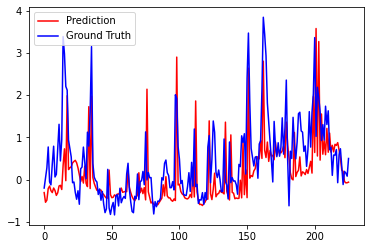

In [217]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()